### Data Loading and Preprocessing

In [2]:
import pandas as pd
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.sample import sample_gen
from scipy.spatial.distance import cdist
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import KNN
from esda.moran import Moran
from esda.getisord import G_Local

##### Load covariates CSVs and GPS shapefiles

In [3]:
cov_mis = pd.read_csv(r'C:\Users\Hp\Documents\capstone_project\data\raw\MIS_COV.csv')  # MIS covariates
cov_dhs = pd.read_csv(r'C:\Users\Hp\Documents\capstone_project\data\raw\DHS_COV.csv')  # DHS covariates
gps_mis_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\MIS_GPS\NGGE81FL.shp')
gps_dhs_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\DHS_GPS\NGGE8AFL.shp')

In [4]:
# Merge covariates with GPS on 'DHSID'
mis_merged = cov_mis.merge(gps_mis_gdf, on='DHSID', how='left')
dhs_merged = cov_dhs.merge(gps_dhs_gdf, on='DHSID', how='left')
mis_merged = gpd.GeoDataFrame(mis_merged, geometry='geometry', crs='EPSG:4326')
dhs_merged = gpd.GeoDataFrame(dhs_merged, geometry='geometry', crs='EPSG:4326')

In [5]:
# Combine
full_gdf = pd.concat([dhs_merged, mis_merged], ignore_index=True)
full_gdf.to_file('data/processed/merged_gdf.geojson', driver='GeoJSON')
print(f"Combined rows: {len(full_gdf)} | Columns: {full_gdf.columns[:10]}")

Combined rows: 1947 | Columns: Index(['DHSID', 'GPS_Dataset', 'DHSCC_x', 'DHSYEAR_x', 'DHSCLUST_x',
       'SurveyID', 'All_Population_Count_2000', 'All_Population_Count_2005',
       'All_Population_Count_2010', 'All_Population_Count_2015'],
      dtype='object')


In [6]:
# Check for duplicates in full_gdf (before proceeding)
duplicates = full_gdf.duplicated(subset=['DHSID'])  # Check on unique ID
print(f"Duplicates found: {duplicates.sum()}")
if duplicates.sum() > 0:
    full_gdf = full_gdf.drop_duplicates(subset=['DHSID'])
    print("Duplicates removed! New rows:", len(full_gdf))

Duplicates found: 0


In [7]:
# Add target (proxy: Malaria_Incidence_2020 > threshold, e.g., mean + std; adjust)
mean_inc = full_gdf['Malaria_Incidence_2020'].mean()
std_inc = full_gdf['Malaria_Incidence_2020'].std()
full_gdf['malaria_risk'] = (full_gdf['Malaria_Incidence_2020'] > mean_inc + std_inc).astype(int)
print("Target added. Risk balance:", full_gdf['malaria_risk'].value_counts(normalize=True))

Target added. Risk balance: malaria_risk
0    0.836158
1    0.163842
Name: proportion, dtype: float64


In [8]:
# Sample Phase 2 rasters at GPS points (with 5km buffer for displacement)
def sample_raster_with_buffer(raster_path, gdf, buffer_km=5):
    # Initialize column as float64 to avoid dtype warning
    gdf['sampled_value'] = 0.0
    
    with rasterio.open(raster_path) as src:
        for idx, row in gdf.iterrows():
            if row.geometry is not None:
                geom_buffer = row.geometry.buffer(buffer_km / 111)
                coords = list(geom_buffer.exterior.coords)
                values = [val[0] for val in src.sample(coords)]
                gdf.at[idx, 'sampled_value'] = np.mean(values) if values else np.nan
    return gdf['sampled_value']

full_gdf['rainfall'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\chirps_nigeria_monthly_mean_2018_2024.tif', full_gdf)
full_gdf['ndvi'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\ndvi_nigeria_mean_2018_2024_2.tif', full_gdf)
full_gdf['temp'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\temp_nigeria_monthly_mean_2018_2024.tif', full_gdf)
full_gdf['elevation'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\srtm_nigeria_elevation.tif', full_gdf)
full_gdf['pop_density'] = sample_raster_with_buffer(r'C:\Users\Hp\Documents\capstone_project\data\raw\nga_pd_2020_1km.tif', full_gdf)

In [9]:
# Distance to roads/water (Phase 2 GeoJSON)
roads_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\osm_roads_nigeria.geojson')
water_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\osm_water_nigeria.geojson')
full_gdf['dist_to_road'] = full_gdf.geometry.apply(lambda p: roads_gdf.distance(p).min() * 111 if p is not None else np.nan)
full_gdf['dist_to_water'] = full_gdf.geometry.apply(lambda p: water_gdf.distance(p).min() * 111 if p is not None else np.nan)

C:\Users\Hp\AppData\Local\Temp\ipykernel_8740\2222687325.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  full_gdf['dist_to_road'] = full_gdf.geometry.apply(lambda p: roads_gdf.distance(p).min() * 111 if p is not None else np.nan)
C:\Users\Hp\AppData\Local\Temp\ipykernel_8740\2222687325.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  full_gdf['dist_to_water'] = full_gdf.geometry.apply(lambda p: water_gdf.distance(p).min() * 111 if p is not None else np.nan)


In [10]:

# Distance to roads/water (Phase 2 GeoJSON)
roads_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\osm_roads_nigeria.geojson')
water_gdf = gpd.read_file(r'C:\Users\Hp\Documents\capstone_project\data\raw\osm_water_nigeria.geojson')

# Assume all data starts in EPSG:4326 (WGS84 geographic). Reproject to a suitable projected CRS for Nigeria.
# Using UTM Zone 32N (EPSG:32632) as it's central; adjust if your data spans multiple zones.
projected_crs = 'EPSG:32632'

full_gdf_projected = full_gdf.to_crs(projected_crs)
roads_gdf_projected = roads_gdf.to_crs(projected_crs)
water_gdf_projected = water_gdf.to_crs(projected_crs)

# Now compute distances in meters, then convert to km by dividing by 1000.
# This avoids the CRS warning and gives accurate distances.
full_gdf['dist_to_road'] = full_gdf_projected.geometry.apply(
    lambda p: roads_gdf_projected.distance(p).min() / 1000 if p is not None else np.nan
)
full_gdf['dist_to_water'] = full_gdf_projected.geometry.apply(
    lambda p: water_gdf_projected.distance(p).min() / 1000 if p is not None else np.nan
)

# Optional: Reproject full_gdf back to original CRS if needed for other operations
full_gdf = full_gdf.to_crs(full_gdf.crs)

In [11]:
# Feature Engineering (lags, indices from covariates/Phase 2)
full_gdf['rainfall_lag1'] = full_gdf['Rainfall_2020'].shift(1, fill_value=0)  # 1-year lag proxy
full_gdf['ndwi'] = (full_gdf['Enhanced_Vegetation_Index_2020'] - full_gdf['Land_Surface_Temperature_2020']) / (full_gdf['Enhanced_Vegetation_Index_2020'] + full_gdf['Land_Surface_Temperature_2020'])  # Proxy
full_gdf['urban_index'] = full_gdf['UN_Population_Density_2020'] + full_gdf['Nightlights_Composite']

In [12]:
# Clean Missing
num_cols = full_gdf.select_dtypes(include=np.number).columns
imputer = SimpleImputer(strategy='mean')
full_gdf[num_cols] = imputer.fit_transform(full_gdf[num_cols])

In [13]:
# Normalize
scaler = StandardScaler()
full_gdf[num_cols] = scaler.fit_transform(full_gdf[num_cols])

full_gdf.to_csv(r'C:\Users\Hp\Documents\capstone_project\data\processed\features_processed.csv', index=False)
print("Preprocessing complete!")

Preprocessing complete!


## Exploratory Data Analysis (EDA)

##### Non-spatial: Distributions, correlations (inspired by paper's Spearman/PCA).

       malaria_risk      rainfall          ndvi  ITN_Coverage_2020  \
count  1.947000e+03  1.947000e+03  1.947000e+03       1.947000e+03   
mean  -7.298847e-18  5.839077e-17  1.459769e-17      -1.459769e-17   
std    1.000257e+00  1.000257e+00  1.000257e+00       1.000257e+00   
min   -4.426578e-01 -6.064016e-01 -4.055671e+00      -1.765797e+00   
25%   -4.426578e-01 -6.064016e-01 -7.958333e-01      -7.800121e-01   
50%   -4.426578e-01 -5.721130e-01 -1.459769e-17      -2.074991e-01   
75%   -4.426578e-01  2.375844e-01  7.900138e-01       6.667476e-01   
max    2.259081e+00  4.482006e+00  2.491338e+00       3.014054e+00   

       UN_Population_Density_2020  
count                 1947.000000  
mean                     0.000000  
std                      1.000257  
min                     -0.378374  
25%                     -0.335193  
50%                     -0.277562  
75%                     -0.076821  
max                     10.759162  


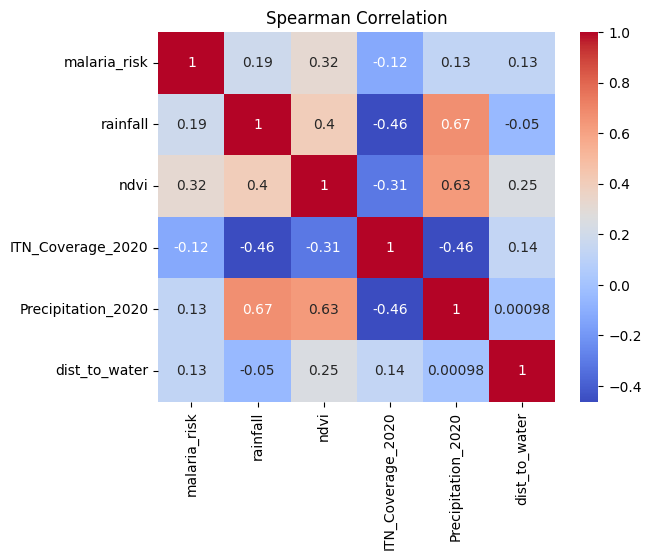

In [20]:
# Descriptive stats
print(full_gdf[['malaria_risk', 'rainfall', 'ndvi', 'ITN_Coverage_2020', 'UN_Population_Density_2020']].describe())

# Histograms
sns.histplot(full_gdf['rainfall'], bins=20)
plt.title('Rainfall Distribution')
plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\eda_rainfall_hist.png')

# Correlation (Spearman, as in paper)
corr_vars = ['malaria_risk', 'rainfall', 'ndvi', 'ITN_Coverage_2020', 'Precipitation_2020', 'dist_to_water']
corr = full_gdf[corr_vars].corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Spearman Correlation')
plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\eda_corr_matrix.png')

##### PCA (As in Paper)

In [ ]:
from sklearn.decomposition import PCA

env_vars = ['Rainfall_2020', 'Enhanced_Vegetation_Index_2020', 'Land_Surface_Temperature_2020', 'Maximum_Temperature_2020', 'PET_2020']  # From cov
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(full_gdf[env_vars].dropna())
print(f"Explained variance: {pca.explained_variance_ratio_ * 100}")

##### Exploratory Spatial Data Analysis (ESDA)
Spatial: Autocorrelation, hotspots (paper's Moran's I/point density)

c:\Users\Hp\miniconda3\envs\geospatial\lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I: 0.5095992544268406 | p-value: 0.001


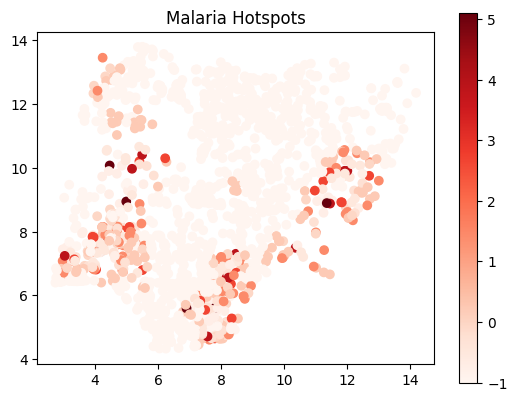

In [23]:
w = KNN.from_dataframe(full_gdf, k=5)
moran = Moran(full_gdf['malaria_risk'], w)
print(f"Moran's I: {moran.I} | p-value: {moran.p_sim}")

gi = G_Local(full_gdf['malaria_risk'], w)
full_gdf['gi_star'] = gi.Gs
full_gdf.plot(column='gi_star', cmap='Reds', legend=True)
plt.title('Malaria Hotspots')
plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\esda_hotspots_map.png')

c:\Users\Hp\miniconda3\envs\geospatial\lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Moran's I: 0.5095992544268406 | p-value: 0.001
Available columns in nigeria_gdf:
['adm1_name', 'adm1_name1', 'adm1_name2', 'adm1_name3', 'adm1_pcode', 'adm0_name', 'adm0_name1', 'adm0_name2', 'adm0_name3', 'adm0_pcode', 'valid_on', 'valid_to', 'area_sqkm', 'version', 'lang', 'lang1', 'lang2', 'lang3', 'adm1_ref_name', 'center_lat', 'center_lon', 'geometry']


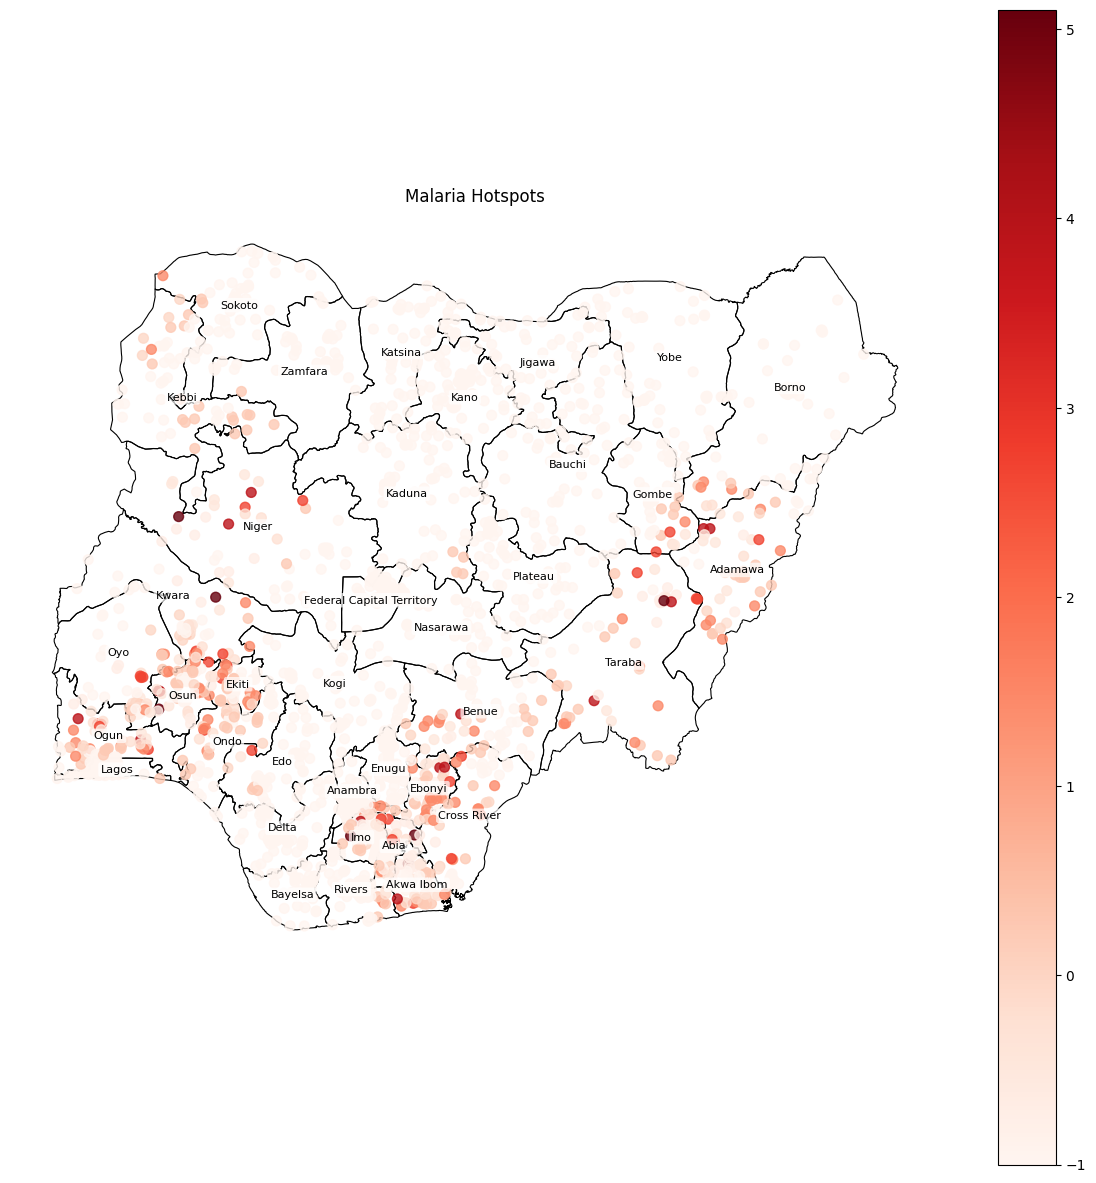

In [25]:
from libpysal.weights import KNN
from esda import Moran, G_Local
import geopandas as gpd
import matplotlib.pyplot as plt

# Your existing code
w = KNN.from_dataframe(full_gdf, k=5)
moran = Moran(full_gdf['malaria_risk'], w)
print(f"Moran's I: {moran.I} | p-value: {moran.p_sim}")

gi = G_Local(full_gdf['malaria_risk'], w)
full_gdf['gi_star'] = gi.Gs

# Ensure CRS is set for full_gdf (assumes lat/long points; confirm your data's projection)
if full_gdf.crs is None:
    full_gdf = full_gdf.set_crs('EPSG:4326')

# Load Nigeria states boundaries from your local GeoJSON file
nigeria_path = r'C:\Users\Hp\Documents\capstone_project\data\raw\nga_admin_boundaries.geojson\nga_admin1.geojson'
nigeria_gdf = gpd.read_file(nigeria_path)

# Print columns to identify the correct state name column
print("Available columns in nigeria_gdf:")
print(nigeria_gdf.columns.tolist())

# Optionally print a sample to see values (uncomment if needed)
#print(nigeria_gdf.head())

# Align CRS if needed (the GeoJSON is likely in EPSG:4326)
if nigeria_gdf.crs != full_gdf.crs:
    nigeria_gdf = nigeria_gdf.to_crs(full_gdf.crs)

# Modified plotting with state boundaries and labels
fig, ax = plt.subplots(figsize=(15, 15))  # Larger size for bigger PNG
nigeria_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8)  # Plot boundaries first

# Add state labels (replace 'ADM1_EN' with the correct column name from the print above, e.g., 'name', 'admin1Name', 'STATE', etc.)
# Run the script once to see the columns, then update this line and re-run
state_name_col = 'adm1_name'  # <-- Change this to the actual column name that contains state names
for idx, row in nigeria_gdf.iterrows():
    ax.text(
        row.geometry.centroid.x, 
        row.geometry.centroid.y, 
        row[state_name_col], 
        fontsize=8, 
        ha='center', 
        va='center',
        color='black',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, boxstyle='round,pad=0.2')
    )

full_gdf.plot(ax=ax, column='gi_star', cmap='Reds', legend=True, markersize=50, alpha=0.8)

ax.set_title('Malaria Hotspots')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off()  # Optional: Remove axis ticks for a cleaner map look

plt.savefig(r'C:\Users\Hp\Documents\capstone_project\data\outputs\esda_hotspots_map.png', dpi=300)  # Higher DPI for better quality/larger file
plt.show()  # Optional: Display the plot

In [ ]:
from libpysal.weights import Queen  # Or KNN
from esda.moran import Moran
from esda.getisord import G_Local

# Spatial weights from clusters
w = Queen.from_dataframe(full_gdf)  # Adjacency; or KNN(full_gdf, k=5)

# Moran's I (spatial autocorrelation for risk)
moran = Moran(full_gdf['malaria_risk'], w)
print(f"Moran's I: {moran.I} | p-value: {moran.p_sim}")

# Hotspots (Getis-Ord Gi*)
gi = G_Local(full_gdf['malaria_risk'], w)
full_gdf['gi_star'] = gi.Gs
full_gdf['gi_p'] = gi.p_sim

# Plot hotspots
full_gdf.plot(column='gi_star', cmap='Reds', legend=True)
plt.title('Malaria Hotspots (Gi*)')
plt.savefig('data/outputs/esda_hotspots_map.png')

full_gdf.to_file('data/processed/esda_results.geojson', driver='GeoJSON')   